# Python Statistics

# 1. Carregar bibliotecas e funções

In [111]:
# Bibiotecas padrão
import pandas as pd
import numpy as np

## Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp

# Escrever as fórmulas dos modelos
import patsy as pt

# Bibioteca estatística
import statsmodels.api as sm

# Fator de inflação da variância
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Bibliotecas do scikitlearn para calcular as métricas e fazer a regressão regularizada
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV

In [2]:
def desc_null(df, percentiles=False):
  """
  Função para descrição de dados, incluindo colunas de contagem de nulos e porcentagem de nulos em cada variável
  """
  if percentiles is True:
    des = df.describe(datetime_is_numeric=True,
                      percentiles=[0.05, 0.25, 0.5, 0.75, 0.9, 0.99]).T
    des["nullCount"] = df.shape[0] - des["count"]
    des["null%"] = (des["nullCount"] / df.shape[0]) * 100

  else:
    des = df.describe(include='all', 
                      datetime_is_numeric=True).T
    des['nullCount'] = df.shape[0] - des['count']
    des['null%'] = (des['nullCount'] / df.shape[0]) * 100
    
  return des

In [3]:
def cat_filter(df, columns, entries):
  import pandas as pd
  filter = {}
  for col in columns:
    cat = df[col].value_counts().sort_values(ascending=True)
    filter = {x: 'Other' for x in cat[cat < entries].index}
  df.loc[:, col] = df[col].replace(filter).copy()
  df = pd.get_dummies(df, columns=columns, drop_first=True)
  return df

In [4]:
def histplot(data, title=None, xlabel=None, ylabel=None, x=None, y=None, ax=False, nrows=1, ncols=1, figsize=(10, 5), bins=10):
  """
  Fast histplot configuration
  """
  import matplotlib.pyplot as plt
  import seaborn as sns
  
  if ax is True:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    c = 0
    if len(x) < (nrows * ncols):      
      for i in range(nrows):
        for j in range(ncols):
          if i == nrows-1 and j == ncols-1:
            fig.delaxes(axes[nrows-1,ncols-1])
          else:
            sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[i,j]).set_ylabel(ylabel)
            c += 1
      
    elif nrows > 1 and ncols > 1:      
      for i in range(nrows):
        for j in range(ncols):
          sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[i,j]).set_ylabel(ylabel)
          c += 1
    elif nrows == 1:
      for j in range(ncols):
        sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[j]).set_ylabel(ylabel)
        c += 1
    elif ncols == 1:
      for i in range(nrows):
        sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[i]).set_ylabel(ylabel)
        c += 1
    if title is not None:
      fig.suptitle(title)
  
  else:
    plt.figure(figsize=figsize)
    sns.histplot(data=data, x=x, y=y, bins=bins)
    
    if title is not None:
      plt.title(title)
    if xlabel is not None:
      plt.xlabel(xlabel)
    if ylabel is not None:
      plt.ylabel(ylabel)
      

  return plt.show()

In [5]:
def corrplot(data):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 7))

    sns.heatmap(
        data=data.corr(),
        cmap=sns.diverging_palette(230, 20, as_cmap=True),
        vmin=-1,
        vmax=1,
        annot=True,
    )

    return plt.show()

In [6]:
def norm_test(df):
    import scipy as sp
    kStat, kPvalue = sp.stats.kstest(df, 'norm')
    return print(f'kStat: {kStat:.3f} \n'
                 f'Pvalue: {kPvalue:.3f}')
    

In [7]:
def feat_scale(x):
    import numpy as np

    # Calcular a média da variável
    mean = np.mean(x, axis=0)

    # Calcular o desvio padrão amostral da variável
    sigma = np.std(x, axis=0, ddof=1)

    # Realizar o escalonamento
    xnorm = (x - mean) / sigma

    return xnorm

In [8]:
def ols_formula(df, dependent_var, *excluded_rows):

    # Listar o nome das colunas do dataframe
    cols = list(df.columns)

    # Remover a variável dependente
    cols.remove(dependent_var)

    # Remover as variáveis excluídas
    for col in excluded_rows:
        cols.remove(col)

    # Retornar a fórmula
    return dependent_var + " ~ " + " + ".join(cols)

In [115]:
def fit_model(y, x):
  import statsmodels.api as sm
  
  reg = sm.OLS(y, x)
  regfit = reg.fit()

  return regfit

In [99]:
def vif_view(x, intercept=False):
    import pandas as pd
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    '''
    Visualizador do fator de variância do modelo
    '''

    if intercept is True:
        vif = pd.DataFrame({'Variáveis': x.columns[1:],
                            'VIF': [variance_inflation_factor(x.values, i + 1)
                                    for i in range(len(x.columns[1:]))]
                            })
    else:
        vif = pd.DataFrame({'Variáveis': x.columns,
                            'VIF': [variance_inflation_factor(x.values, i + 1)
                                    for i in range(len(x.columns))]
                            })
    return vif


In [106]:
def predict_table(y, fit, columns, residual=False):
    import pandas as pd
    
    '''
    Cria uma tabela concatenando os valores reais e previstos, com opção de inserir uma coluna de Resíduos
    '''
    
    pred = pd.concat([y, fit], axis=1)
    pred.columns = columns

    if residual is True:
        pred['Res'] = pred[columns[0]] - pred[columns[1]]

    return pred

In [154]:
def adj_quality(pred):
    import pandas as pd
    import numpy as np
    from sklearn import metrics
    
    '''
    Cria um dataframe com as informações de qualidade do modelo
    '''

    adj = pd.DataFrame({
        'R²': metrics.r2_score(pred.loc[:, pred.columns[0]], 
                               pred.loc[:, pred.columns[1]]),
        'RMSE': np.sqrt(metrics.mean_squared_error(pred.loc[:, pred.columns[0]], 
                                                   pred.loc[:, pred.columns[1]]))
    }, index=[0])

    return adj


In [10]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

# 2. Carregar os dados

**Database**: https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

Contém informações sobre carros e gasto de combustível

In [11]:
# Database
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

## Nomenclatura das colunas: https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names
cols = ['mpg', 'cyl', 'disp', 'hp', 'weight', 'acc', 'year', 'origin', 'name']

In [12]:
# Read table para visualizar dados delimitados por espaço
df = pd.read_table(url, header=None, 
                   delim_whitespace=True, 
                   names=cols)

In [13]:
df.head()

,mpg,cyl,disp,hp,weight,acc,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


# 3. Exploratory Data Analysis - Análise Exploratória de dados

A base de dados não possui valores nulos e possui 398 entradas.

| **Feature**  | **Descrição**                                               | **Tipo**   | **Range**    | **Valores únicos**                              
| :----------: | ----------------------------------------------------------- | :--------: | :----------: | ------------------ 
| mpg          | Quantidade de milhas por galão de gasolina, consumo médio   | Numérico   | 9.0 - 46.6   | 
| cyl          | Quantidade de cilindros no motor do carro                   | Numérico   | 3 - 8        |     
| disp         | Quantidade de força que o motor pode gerar                  | Numérico   | 68  - 455    | 
| hp           | Cavalos de força do motor                                   | Numérico   |              | 94  
| weight       | Peso do veículo (lb/1000)                                   | Numérico   | 1613 - 5140  |  
| acc          | Aceleração                                                  | Numérico   | 8.0 - 24.8   | 
| year         | Ano de fabricação do veículo                                | Categórico | 70 - 82      |
| origin       | Origem do carro:  1. Americano, 2. Europeu e 3. Japones     | Categórico |   1 - 3      | 
| name         | Nome do modelo                                              | Categórico |              | 305

In [14]:
desc_null(df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,nullCount,null%
mpg,398.0,NaN,NaN,NaN,23.514573,7.815984,9.0,17.5,23.0,29.0,46.6,0.0,0.0
cyl,398.0,NaN,NaN,NaN,5.454774,1.701004,3.0,4.0,4.0,8.0,8.0,0.0,0.0
disp,398.0,NaN,NaN,NaN,193.425879,104.269838,68.0,104.25,148.5,262.0,455.0,0.0,0.0
hp,398,94,150.0,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
weight,398.0,NaN,NaN,NaN,2970.424623,846.841774,1613.0,2223.75,2803.5,3608.0,5140.0,0.0,0.0
acc,398.0,NaN,NaN,NaN,15.56809,2.757689,8.0,13.825,15.5,17.175,24.8,0.0,0.0
year,398.0,NaN,NaN,NaN,76.01005,3.697627,70.0,73.0,76.0,79.0,82.0,0.0,0.0
origin,398.0,NaN,NaN,NaN,1.572864,0.802055,1.0,1.0,1.0,2.0,3.0,0.0,0.0
name,398,305,ford pinto,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


## 3.1. Separação das variáveis

### 3.1.1. Variáveis categóricas

Separar as variáveis categóricas para análise posterior.

In [15]:
cat = ['year', 'origin', 'name']

for c in cat:
    df[c] = df[c].astype('category')

df[cat].head()

,year,origin,name
0,70,1,chevrolet chevelle malibu
1,70,1,buick skylark 320
2,70,1,plymouth satellite
3,70,1,amc rebel sst
4,70,1,ford torino


### 3.1.2. Variáveis numéricas

A variável **hp** constava com objeto, sendo necessário trocar o valor **?** por **np.nan** e realizar a conversão para float.

In [16]:
df['hp'].replace(to_replace='?', 
                 value=np.nan, 
                 inplace=True)

df['hp'] = df['hp'].astype('float64')

num = list(df.select_dtypes(include='number'))
num.remove('mpg')

In [17]:
df['hp'].fillna(method='pad', inplace=True)

In [18]:
desc_null(df[num], percentiles=True)

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max,nullCount,null%
cyl,398.0,5.454774,1.701004,3.0,4.000,4.000,4.0,8.000,8.0,8.000,8.0,0.0,0.0
disp,398.0,193.425879,104.269838,68.0,85.000,104.250,148.5,262.000,350.0,440.420,455.0,0.0,0.0
hp,398.0,104.178392,38.294837,46.0,60.850,75.000,92.5,125.000,155.9,220.150,230.0,0.0,0.0
weight,398.0,2970.424623,846.841774,1613.0,1923.500,2223.750,2803.5,3608.000,4275.2,4951.030,5140.0,0.0,0.0
acc,398.0,15.568090,2.757689,8.0,11.285,13.825,15.5,17.175,19.0,22.239,24.8,0.0,0.0


### 3.1.3. Variável resposta

In [19]:
resp = 'mpg'

df[resp].head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

## 3.2. Distribuição das variáveis

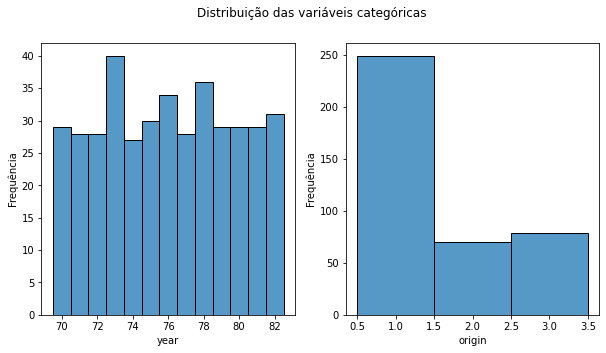

In [20]:
histplot(data=df[cat], 
         title='Distribuição das variáveis categóricas', 
         ylabel='Frequência',
         x=['year', 'origin'], ax=True,
         ncols=2, bins=15,
         figsize=(10,5))

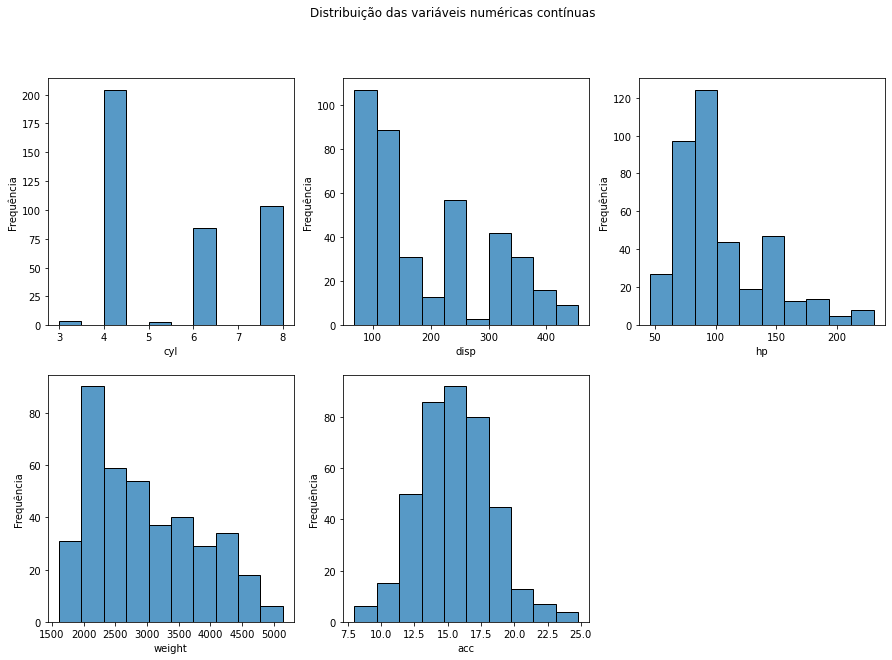

In [21]:
histplot(data=df[num], 
         title='Distribuição das variáveis numéricas contínuas', 
         ylabel='Frequência',
         x=num, ax=True,
         ncols=3, nrows=2,
         figsize=(15,10))

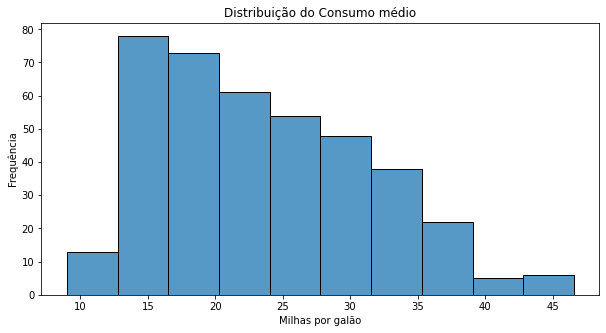

In [22]:
histplot(data=df, x=resp,
         ylabel='Frequência', xlabel='Milhas por galão',
         title='Distribuição do Consumo médio')

A resposta não possui uma distribui distribuição normal e pode dificultar a regressão linear, necessário ser transformada

# 4. Pré Tratamento de dados

## 4.1. Resposta
Antes de realizar uma transformação, realizar um teste de normalidade com o intuito de quantificar o desvio.

In [23]:
norm_test(df[resp])

kStat: 1.000 
Pvalue: 0.000


Como o Pvalue é muito baixo, a resposta deve ser transformada. Uma transformação muito comum para dados assimétricos é a logaritmo natural.
* Atenção, os dados devem ser > 0

### 4.1.1. Transformação da Resposta - **ln**

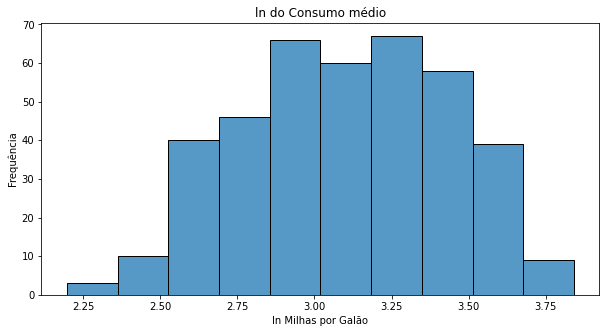

In [24]:
histplot(data=np.log(df[resp]), title='ln do Consumo médio',
         ylabel='Frequência', xlabel='ln Milhas por Galão')

In [25]:
norm_test(np.log(df[resp]))

kStat: 0.987 
Pvalue: 0.000


Apesar de ser mais normalizado, ainda possui uma frequência assimétrica. Apesar do kStat ter melhorado, Pvalue ianda não atingiu o parâmetro necessário.

### 4.1.2. Transformação Box-Cox
Encontrar um exponente que leva a um desvio padrão menor da resposta - achata o gráfico para que ele se pareça mais com a distribuição normal.

Alpha representa o intervalo de confiança.

In [26]:
boxcox = sp.stats.boxcox(df[resp], alpha=0.01)
print(f'Melhor valor da transformação: {boxcox[1]: .3f} \n'
      f'Intervalo de confiança 99%: {boxcox[2]}')

Melhor valor da transformação:  0.197 
Intervalo de confiança 99%: (-0.18013781883434132, 0.577186423120012)


Com esses resultados, há duas possibilidades:
1. usar o valor do lambda ideal 0.197
2. usar um valor aproximado que está dentro do intervalo de confiança, nesse caso, 0.5 - que representa sua raiz quadrada

#### 4.1.2.1. Lambda ideal 0.197

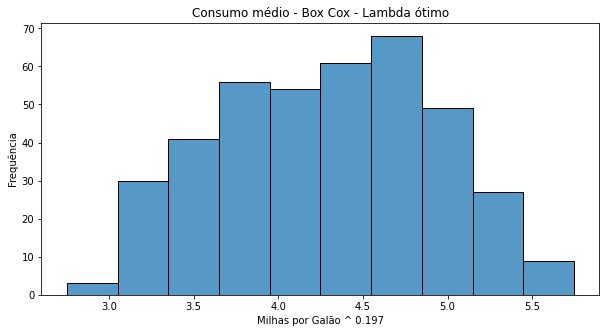

In [27]:
histplot(data=boxcox[0], title='Consumo médio - Box Cox - Lambda ótimo',
         ylabel='Frequência', xlabel='Milhas por Galão ^ 0.197')

In [28]:
norm_test(boxcox[0])

kStat: 0.997 
Pvalue: 0.000


#### 4.1.2.2. Lambda 0.5

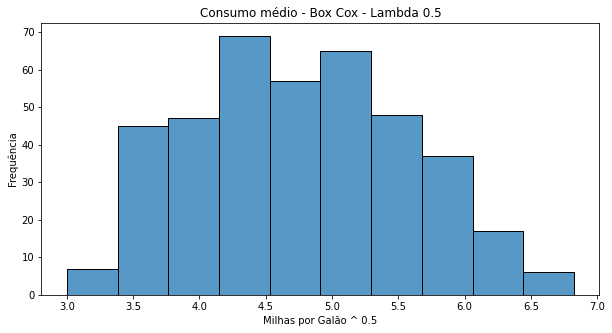

In [29]:
histplot(data=np.sqrt(df[resp]), title='Consumo médio - Box Cox - Lambda 0.5',
         ylabel='Frequência', xlabel='Milhas por Galão ^ 0.5')

In [30]:
norm_test(np.sqrt(df[resp]))

kStat: 0.999 
Pvalue: 0.000


Nenhuma transformada foi capaz de normalizar a resposta numericamente, mas pelo menos diminuiram a assimetria.

Vamos seguir utilizando **ln** pelas seguintes razões:
* é a transformada mais historicamente utilizada, 
* é fácil de converter à escala original **exp(log(y))**
* apresento o menor kStat

In [31]:
yLog = np.log(df[resp])

## 4.2. Variáveis numéricas

In [32]:
xNorm = feat_scale(df[num])

xNorm.head()

,cyl,disp,hp,weight,acc
0,1.496308,1.089233,0.674284,0.630077,-1.293870
1,1.496308,1.501624,1.588246,0.853259,-1.475181
2,1.496308,1.194728,1.196548,0.549778,-1.656492
3,1.496308,1.060461,1.196548,0.546236,-1.293870
4,1.496308,1.041280,0.935416,0.565130,-1.837804


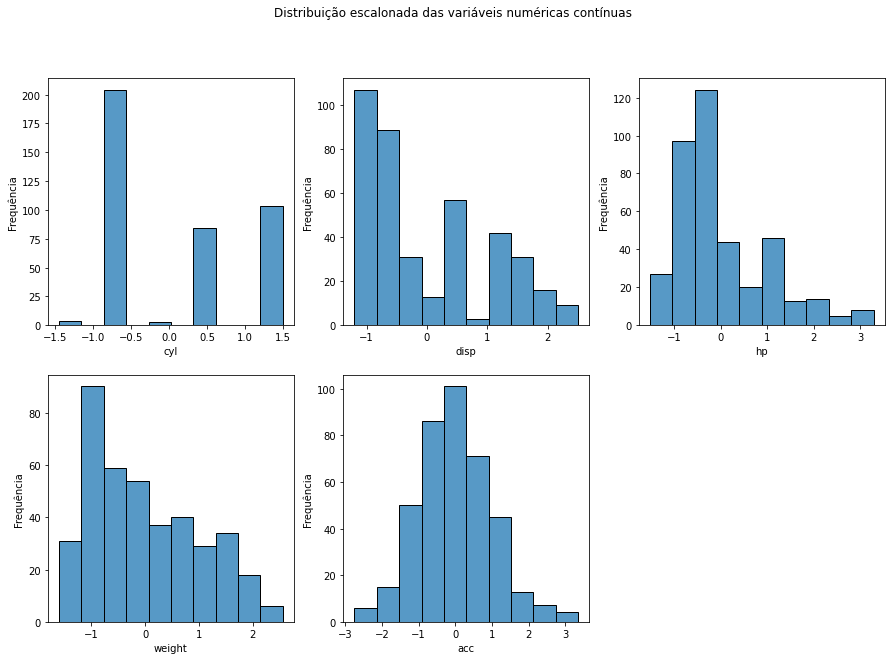

In [33]:
histplot(data=xNorm, 
         title='Distribuição escalonada das variáveis numéricas contínuas', 
         ylabel='Frequência',
         x=num, ax=True,
         ncols=3, nrows=2,
         figsize=(15,10))

O escalonamento não foi capaz de alterar a assimetria das variáveis, elas apenas mudaram de escala. Todos estão com escala numérica similar (-3 a 3) facilitando na comparação dos betas.

In [34]:
np.mean(xNorm)

cyl      -5.065741e-16
disp     -8.256935e-17
hp       -4.518998e-16
weight   -9.637740e-17
acc       5.479704e-15
dtype: float64

In [35]:
np.std(xNorm, ddof=1)

cyl       1.0
disp      1.0
hp        1.0
weight    1.0
acc       1.0
dtype: float64

Agoras as novas variáveis possuem média muito próxima a 0 e desvio padrão de 1

### 4.2.1. Avaliação da multicolinearidade

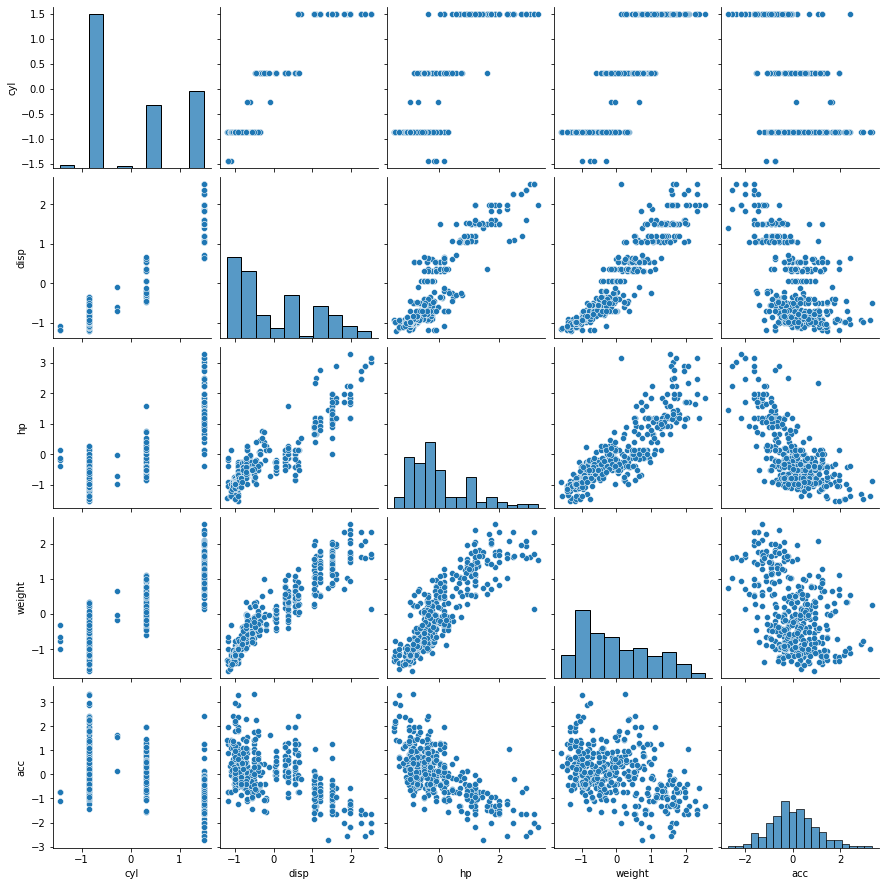

In [36]:
sns.pairplot(xNorm)

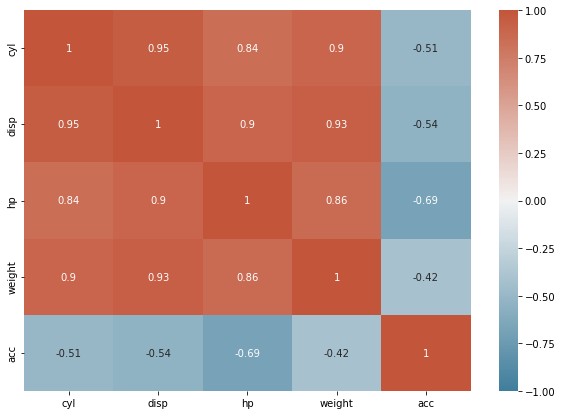

In [37]:
corrplot(xNorm)

Correlações muito altas podem trazer problemas para a modelagem.

## 4.3. Variáveis categóricas

In [38]:
df['brand'] = df['name'].str.split(n=1, expand=True)[0]

cat = ['year', 'origin', 'brand']

In [39]:
xCat = cat_filter(df.loc[:, cat], cat, 8)

xCat.head()

,year_71,year_72,year_73,year_74,year_75,year_76,year_77,year_78,year_79,year_80,year_81,year_82,origin_2,origin_3,brand_amc,brand_buick,brand_chevrolet,brand_datsun,brand_dodge,brand_fiat,brand_ford,brand_honda,brand_mazda,brand_mercury,brand_oldsmobile,brand_peugeot,brand_plymouth,brand_pontiac,brand_toyota,brand_volkswagen
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


# 5. Ajuste de Modelo e Significância

## 5.1. Y em escala original
Criar um dataset concatenando os dados originais.

In [74]:
y = df['mpg']

df_original = pd.concat([xNorm, xCat, y], axis=1)
df_Num = pd.concat([xNorm, y], axis=1)
df_Cat = pd.concat([xCat, y], axis=1)

In [73]:
df_original.head()

,cyl,disp,hp,weight,acc,year_71,year_72,year_73,year_74,year_75,year_76,year_77,year_78,year_79,year_80,year_81,year_82,origin_2,origin_3,brand_amc,brand_buick,brand_chevrolet,brand_datsun,brand_dodge,brand_fiat,brand_ford,brand_honda,brand_mazda,brand_mercury,brand_oldsmobile,brand_peugeot,brand_plymouth,brand_pontiac,brand_toyota,brand_volkswagen,mpg
0,1.496308,1.089233,0.674284,0.630077,-1.293870,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,18.0
1,1.496308,1.501624,1.588246,0.853259,-1.475181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0
2,1.496308,1.194728,1.196548,0.549778,-1.656492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,18.0
3,1.496308,1.060461,1.196548,0.546236,-1.293870,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.0
4,1.496308,1.041280,0.935416,0.565130,-1.837804,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,17.0


### 5.1.1. Matriz do modelo

#### 5.1.1.1. Valores numéricos

In [75]:
y, xNum = pt.dmatrices(ols_formula(df_Num, 'mpg'),
                       data=df_Num, return_type='dataframe')

In [84]:
regfit_original = fit_model(y, xNum)

print(regfit_original.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     189.0
Date:                Mon, 09 May 2022   Prob (F-statistic):          4.65e-102
Time:                        15:14:49   Log-Likelihood:                -1138.5
No. Observations:                 398   AIC:                             2289.
Df Residuals:                     392   BIC:                             2313.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.5146      0.214    110.138      0.0

In [103]:
vif_view(xNum, intercept=True)

,Variáveis,VIF
0,cyl,10.583673
1,disp,19.669973
2,hp,8.715777
3,weight,10.251677
4,acc,2.549044


Valores "saudáveis" de VIF são menores que 5, menores que 10 também podem ser aceitadas. A solução é tentar remover um fator para diminuir o VIF, usualmente o de maior valor.

In [81]:
y, xNum2 = pt.dmatrices(ols_formula(df_Num, 'mpg', 'disp'),
                     data=df_Num, return_type='dataframe')

In [82]:
regfit2_original = fit_model(y, xNum2)

print(regfit2_original.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     236.8
Date:                Mon, 09 May 2022   Prob (F-statistic):          2.84e-103
Time:                        15:08:52   Log-Likelihood:                -1138.5
No. Observations:                 398   AIC:                             2287.
Df Residuals:                     393   BIC:                             2307.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.5146      0.213    110.278      0.0

In [102]:
vif_view(xNum2, intercept=True)

,Variáveis,VIF
0,cyl,5.745727
1,hp,8.100434
2,weight,8.241326
3,acc,2.520378


Sem a variável **disp**, os valores de VIF estão mais próximos de limites aceitáveis.

#### 5.1.1.2. Valores categóricos

In [85]:
y, xCat = pt.dmatrices(ols_formula(df_Cat, 'mpg'),
                       data=df_Cat, return_type='dataframe')

In [87]:
regfit3_original = fit_model(y, xCat)

regfit3_original.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     24.65
Date:                Mon, 09 May 2022   Prob (F-statistic):           4.07e-70
Time:                        15:18:16   Log-Likelihood:                -1163.0
No. Observations:                 398   AIC:                             2388.
Df Residuals:                     367   BIC:                             2512.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           12.9169      1.488      8.681      0.000       9.991      15.843
year_71              2.8970      1.255      2.308      0.022       0.429       5.365
year_72              0.1746      1.251      0.140      0.889      -2.285       2.635
year_73             -1.1138      1.155     -0.964      0.336      -3.386       1.158
year_74              2.7735      1.277      2.171      0.031       0.262       5.285
year_75              1.8364      1.226      1.498      0.135      -0.574       4.247
year_76              3.0255      1.193      2.537      0.012       0.680       5.371
year_77              4.5346      1.259      3.601      0.000       2.059       7.011
year_78              4.9748      1.188      4.188      0.000       2.639       7.311
year_79              7.7557      1.246      6.222      0.000       5.305      10.207
year_80             12.0925      1.283      9.426      0.000       9.570      14.615
year_81             10.0971      1.257      8.035      0.000       7.626      12.568
year_82             13.0731      1.236     10.579      0.000      10.643      15.503
origin_2             9.8631      1.485      6.641      0.000       6.943      12.784
origin_3            10.0597      2.096      4.800      0.000       5.938      14.181
brand_amc            2.5396      1.551      1.638      0.102      -0.510       5.589
brand_buick          2.0189      1.706      1.184      0.237      -1.335       5.373
brand_chevrolet      3.5025      1.455      2.408      0.017       0.642       6.363
brand_datsun         2.1040      1.933      1.088      0.277      -1.698       5.905
brand_dodge          3.9865      1.544      2.581      0.010       0.950       7.023
brand_fiat           3.6611      1.867      1.961      0.051      -0.010       7.332
brand_ford           2.6878      1.427      1.884      0.060      -0.118       5.494
brand_honda          2.6528      2.121      1.251      0.212      -1.517       6.823
brand_mazda         -1.3468      2.239     -0.602      0.548      -5.749       3.055
brand_mercury        2.0422      1.910      1.069      0.286      -1.713       5.798
brand_oldsmobile     3.0718      1.962      1.566      0.118      -0.786       6.930
brand_peugeot       -2.9376      1.840     -1.597      0.111      -6.555       0.680
brand_plymouth       5.2481      1.523      3.445      0.001       2.253       8.244
brand_pontiac        2.7111      1.731      1.566      0.118      -0.693       6.115
brand_toyota        -0.0639      1.913     -0.033      0.973      -3.827       3.699
brand_volkswagen     2.7405      1.446      1.895      0.059      -0.103       5.584
==============================================================================
Omnibus:                       16.110   Durbin-Watson:                   1.132
Prob(Omnibus):                  0.0

O coeficiente representa o que ocorre com o valor da resposta, representa a mudança no intercept

In [101]:
vif_view(xCat, intercept=True)

,Variáveis,VIF
0,year_71,1.871017
1,year_72,1.858659
2,year_73,2.191471
3,year_74,1.873328
4,year_75,1.902197
5,year_76,2.017507
6,year_77,1.882778
7,year_78,2.107699
8,year_79,1.905822
9,year_80,2.019093


#### 5.1.1.3. Modelo com todas as variáveis

In [90]:
df_original.head()

,cyl,disp,hp,weight,acc,year_71,year_72,year_73,year_74,year_75,year_76,year_77,year_78,year_79,year_80,year_81,year_82,origin_2,origin_3,brand_amc,brand_buick,brand_chevrolet,brand_datsun,brand_dodge,brand_fiat,brand_ford,brand_honda,brand_mazda,brand_mercury,brand_oldsmobile,brand_peugeot,brand_plymouth,brand_pontiac,brand_toyota,brand_volkswagen,mpg
0,1.496308,1.089233,0.674284,0.630077,-1.293870,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,18.0
1,1.496308,1.501624,1.588246,0.853259,-1.475181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0
2,1.496308,1.194728,1.196548,0.549778,-1.656492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,18.0
3,1.496308,1.060461,1.196548,0.546236,-1.293870,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.0
4,1.496308,1.041280,0.935416,0.565130,-1.837804,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,17.0


In [91]:
y, x = pt.dmatrices(ols_formula(df_original, 'mpg', 'disp'),
                     data=df_original, return_type='dataframe')

##### 5.1.1.3.1. Dividir o dataset

In [92]:
x_Train, x_Test, y_Train, y_Test = train_test_split(x, y, test_size=0.2, random_state=0)

In [93]:
data = (x_Train, x_Test, y_Train, y_Test)

for d in data:
    d.reset_index(drop=True, inplace=True)

##### 5.1.1.3.2. Ajustar o modelo

In [116]:
regfit4_original = fit_model(y_Train, x_Train)
regfit4_original.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     54.56
Date:                Mon, 09 May 2022   Prob (F-statistic):          1.75e-104
Time:                        22:47:19   Log-Likelihood:                -781.44
No. Observations:                 318   AIC:                             1633.
Df Residuals:                     283   BIC:                             1765.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           19.4752      1.266     15.379      0.000      16.983      21.968
cyl                  1.0001      0.452      2.212      0.028       0.110       1.890
hp                  -0.7221      0.585     -1.234      0.218      -1.874       0.430
weight              -4.8423      0.557     -8.698      0.000      -5.938      -3.747
acc                  0.4322      0.291      1.488      0.138      -0.140       1.004
year_71              1.0729      1.013      1.059      0.290      -0.921       3.066
year_72              0.5125      1.013      0.506      0.613      -1.482       2.507
year_73             -0.2457      0.928     -0.265      0.791      -2.073       1.582
year_74              1.6958      1.078      1.573      0.117      -0.426       3.818
year_75              1.0076      1.059      0.951      0.342      -1.077       3.092
year_76              1.4459      0.999      1.447      0.149      -0.520       3.412
year_77              2.9520      1.035      2.853      0.005       0.916       4.988
year_78              2.4875      0.963      2.583      0.010       0.592       4.384
year_79              4.2412      1.064      3.986      0.000       2.147       6.335
year_80              9.4280      1.076      8.759      0.000       7.309      11.547
year_81              7.4204      1.086      6.831      0.000       5.282       9.559
year_82              8.2048      1.049      7.824      0.000       6.141      10.269
origin_2             2.2909      1.161      1.973      0.049       0.005       4.577
origin_3             0.8602      1.644      0.523      0.601      -2.375       4.095
brand_amc           -1.6491      1.192     -1.383      0.168      -3.995       0.697
brand_buick          0.6188      1.288      0.480      0.631      -1.917       3.155
brand_chevrolet      0.0232      1.115      0.021      0.983      -2.172       2.218
brand_datsun         2.4015      1.447      1.659      0.098      -0.447       5.250
brand_dodge          0.2111      1.180      0.179      0.858      -2.112       2.534
brand_fiat           0.1289      1.403      0.092      0.927      -2.633       2.891
brand_ford          -1.0968      1.094     -1.003      0.317      -3.250       1.057
brand_honda          2.7002      1.503      1.797      0.073      -0.258       5.659
brand_mazda          1.2397      1.599      0.775      0.439      -1.909       4.388
brand_mercury       -0.4465      1.516     -0.295      0.768      -3.430       2.537
brand_oldsmobile     1.6118      1.481      1.088      0.277      -1.304       4.527
brand_peugeot       -0.8198      1.399     -0.586      0.558      -3.574       1.935
brand_plymouth       1.1086      1.155      0.960      0.338      -1.165       3.382
brand_pontiac        2.7658      1.262      2.192      0.029       0.282       5.250
brand_toyota         0.

Uma das maneiras de tratar os dados poderia ser através da remoção das variáveis com pvalue muito grande

In [104]:
vif_view(x_Train, intercept=True)

,Variáveis,VIF
0,cyl,7.267746
1,hp,11.607547
2,weight,10.915357
3,acc,2.863563
4,year_71,2.538615
5,year_72,2.245604
6,year_73,2.842398
7,year_74,2.542771
8,year_75,2.562131
9,year_76,2.842100


##### 5.1.1.3.3. Avaliação da qualidade de ajuste
Prever os valores utilizando os dados de teste

In [155]:
predY = predict_table(y= y_Test,
                     fit= regfit4_original.predict(x_Test),
                     columns= ['mpgReal', 'mpgPrevisto'],
                     residual=True)
predY.head()

,mpgReal,mpgPrevisto,Res
0,14.0,12.439389,1.560611
1,25.0,23.563378,1.436622
2,13.0,12.211237,0.788763
3,21.0,21.494649,-0.494649
4,18.0,17.471713,0.528287


In [153]:
adj_quality(predY)

,R²,RMSE
0,0.831914,3.265931


## 5.2. Y em escala logaritmica

In [44]:
df_log = pd.concat([xNorm, xCat, yLog], axis=1)